importing packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# moseq dataframes
moseq_df=pd.read_csv('./moseq_df.csv')
stats_df=pd.read_csv('./stats_df.csv')

figure 7F

In [3]:
from tqdm.auto import trange
def permutation_test(box, rest, sample_size = 99999):
    x = np.hstack([box, rest])
    n_box = len(box)
    perm_mean = np.zeros(sample_size)
    for i in trange(sample_size):
        np.random.seed(i) 
        # compute shuffle box mean - rest mean
        perm_x = np.random.permutation(x)
        perm_mean[i] = perm_x[:n_box].mean() - perm_x[n_box:].mean()
    return (np.sum((box.mean()-rest.mean())<perm_mean) +1)/ (sample_size+1)
from scipy.stats import ttest_ind

def bootstrap(box, rest, sample_size = 1000, sample_iter=100000):
    b_mean_box = np.zeros(sample_iter)
    b_mean_rest= np.zeros(sample_iter)
    for i in trange(sample_iter):
        np.random.seed(i)
        b_mean_box[i]=np.random.choice(box, sample_size).mean()
        b_mean_rest[i]=np.random.choice(rest, sample_size).mean()
    return np.percentile(b_mean_box, [2.5,97.5]), np.percentile(b_mean_rest, [2.5, 97.5])
    

In [4]:
def relative_usage(genotype_kinematics, ref, sort_by = 'velocity_2d_mm_mean'):
    relative_u = pd.pivot_table(genotype_kinematics, values = 'usage', index='syllable', columns = 'group').reset_index()
    relative_u['HT'] = relative_u['HT']/relative_u['WT']
    relative_u['KO'] = relative_u['KO']/relative_u['WT']
    relative_u['WT'] = relative_u['WT']/relative_u['WT']
    
    relative_u = pd.merge(relative_u, ref, left_on='syllable', right_on='syllable')
    # only use the top99% ones
    relative_u = relative_u[relative_u.syllable < 49].copy()
    relative_u = relative_u.sort_values(by=[sort_by], ascending=False).reset_index()
    fig, ax = plt.subplots(1, 1, figsize=(20,10))
    sns.lineplot(data = relative_u[['WT', 'HT', 'KO']], ax = ax, dashes=False)
    ax.set_title(f'Syllale in order of {sort_by} high to low', fontsize = 30)


In [5]:
def rolling_usage(genotype_kinematics, ref, roll_num, sort_by = 'velocity_2d_mm_mean', filename='velocity_2d_mm_mean'):
    relative_u = pd.pivot_table(genotype_kinematics, values = 'usage', index='syllable', columns = 'group').reset_index()
    relative_u = pd.merge(relative_u, ref, left_on='syllable', right_on='syllable')
    relative_u = relative_u[relative_u.syllable < 49].copy()
    relative_u = relative_u.sort_values(by=[sort_by], ascending=False).reset_index()
    rolling = pd.DataFrame({
                            'WT': relative_u['WT'].rolling(roll_num).mean(),
                           'HT': relative_u['HT'].rolling(roll_num).mean(),
                           'KO': relative_u['KO'].rolling(roll_num).mean()}).dropna()
    rolling['HT'] =rolling['HT']/rolling['WT']
    rolling['KO'] =rolling['KO']/rolling['WT']
    rolling['WT'] =rolling['WT']/rolling['WT']
    fig, ax = plt.subplots(1, 1, figsize=(20,10))
    sns.lineplot(data = rolling, ax = ax, dashes=False, palette=['b','r','g'])
    ax.set_title(f'Syllale in order of {sort_by} high to low', fontsize = 30)
    # ax.set_xticks([])
    fig.savefig(f'{filename}.pdf')
    return relative_u, rolling

In [6]:
def plot_boxvsrest(stats_df, box, boxname, pair, metric, filename):

    stats_subset = stats_df.loc[(stats_df.group ==pair[0]) | (stats_df.group==pair[1])].copy()
    stats_subset[metric] *= 30
    print(stats_subset.group.unique())
    stats_subset = stats_subset.groupby(['syllable']).mean().reset_index()
    stats_subset['syllable_group'] = 'rest'
    stats_subset.loc[stats_subset['syllable'].isin(box), 'syllable_group'] = 'box'
    print(box)
    box_data = stats_subset[stats_subset['syllable_group'] == 'box'][metric]
    rest_data = stats_subset[stats_subset['syllable_group'] == 'rest'][metric]

    fig, axs = plt.subplots(1,1, figsize=(5,5))
    sns.set_theme(style="whitegrid")
    sns.boxplot(ax= axs, x = 'syllable_group', y = metric, data=stats_subset)
    sns.stripplot(ax= axs, x = 'syllable_group', y = metric, data=stats_subset, color='black')
    axs.set_xlabel('Syllable group')
    axs.set_ylabel(metric)
    axs.set_title(f'{boxname} syllables VS rest')
    plt.show()
    fig.savefig(f'{filename}-{boxname}.pdf')
    print('file name', f'{filename}-{boxname}.pdf')
    stats_subset[['syllable_group','syllable', metric]].to_csv(f'{filename}-{boxname}.csv',index=False)
    return box_data, rest_data    

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

genotype_kinematics = stats_df[['group', 'uuid', 'syllable', 'usage', 'velocity_2d_mm_mean', 'dist_to_center_px_mean']].copy().groupby(['group', 'syllable']).mean().reset_index()
syll_v = genotype_kinematics.groupby('syllable').mean()['velocity_2d_mm_mean'].reset_index()
syll_d = genotype_kinematics.groupby('syllable').mean()['dist_to_center_px_mean'].reset_index()


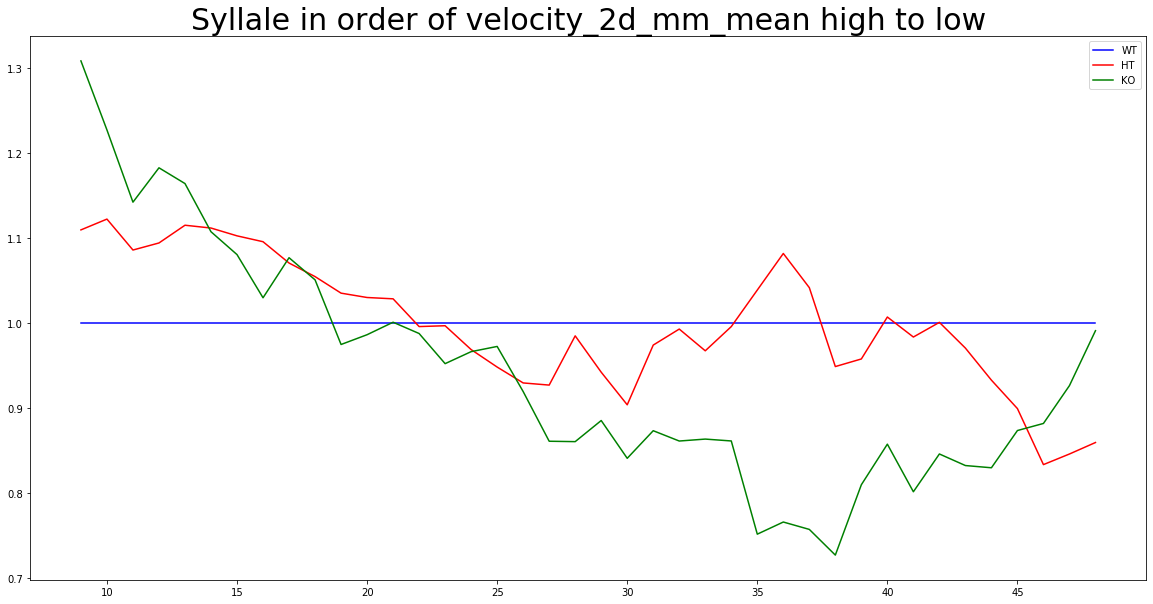

In [8]:
# binnning every 10 syll
relative_u, rolling = rolling_usage(genotype_kinematics, syll_v, 10, sort_by = 'velocity_2d_mm_mean', filename='velocityhightolow')

figure 7G

['HT' 'WT']
[26, 18, 5, 25, 17, 20, 4, 11, 34, 21, 13, 15, 8, 16, 2]


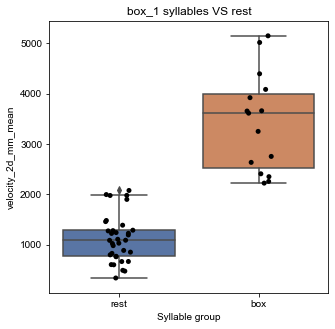

file name htwtvh-to-lspeed_NEW-box_1.pdf


[26, 18, 5, 25, 17, 20, 4, 11, 34, 21, 13, 15, 8, 16, 2]

In [9]:
box_1 = relative_u['syllable'][:15].tolist()
name = 'box_1'
pair = ('HT', 'WT')
box, rest = plot_boxvsrest(stats_df, box_1, name,pair, 'velocity_2d_mm_mean', 'htwtvh-to-lspeed_NEW')

[26, 18, 5, 25, 17, 20, 4, 11, 34, 21, 13, 15, 8, 16, 2]

In [10]:
print(permutation_test(box, rest))
print(ttest_ind(box, rest, equal_var=False))
b_ci, r_ci = bootstrap(box,rest)
print('box CI:', b_ci, 'rest CI:', r_ci)

  1%|          | 858/100000 [00:00<00:11, 8572.36it/s]

1e-05
Ttest_indResult(statistic=8.71260763042814, pvalue=1.1839512266314715e-07)


100%|██████████| 100000/100000 [00:10<00:00, 9689.35it/s]


box CI: [3366.92595926 3484.27149864] rest CI: [1090.14980789 1147.3342297 ]


figure 7H

In [11]:
dist_df = pd.read_csv('./dist_df.csv')
dist_subset = dist_df[dist_df.total_distance< 207].copy()

['HT' 'WT']
[26, 18, 5, 25, 17, 20, 4, 11, 34, 21, 13, 15, 8, 16, 2]


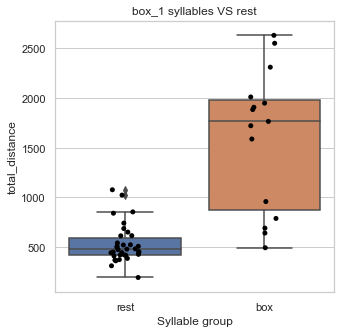

file name htwtvh-to-ldistance_NEW-box_1.pdf


In [12]:
box = relative_u['syllable'][:15].tolist()
name = 'box_1'
pair = ('HT', 'WT')
box, rest = plot_boxvsrest(dist_subset, box, name,pair, 'total_distance', 'htwtvh-to-ldistance_NEW')

figure S8CD

35968
41
(array([550., 600., 650., 700., 750., 800., 850., 900., 950.]), <a list of 9 Text xticklabel objects>)


/Users/sherry/miniconda3/envs/moseq2-dev/lib/python3.7/site-packages/ipykernel_launcher.py:101: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


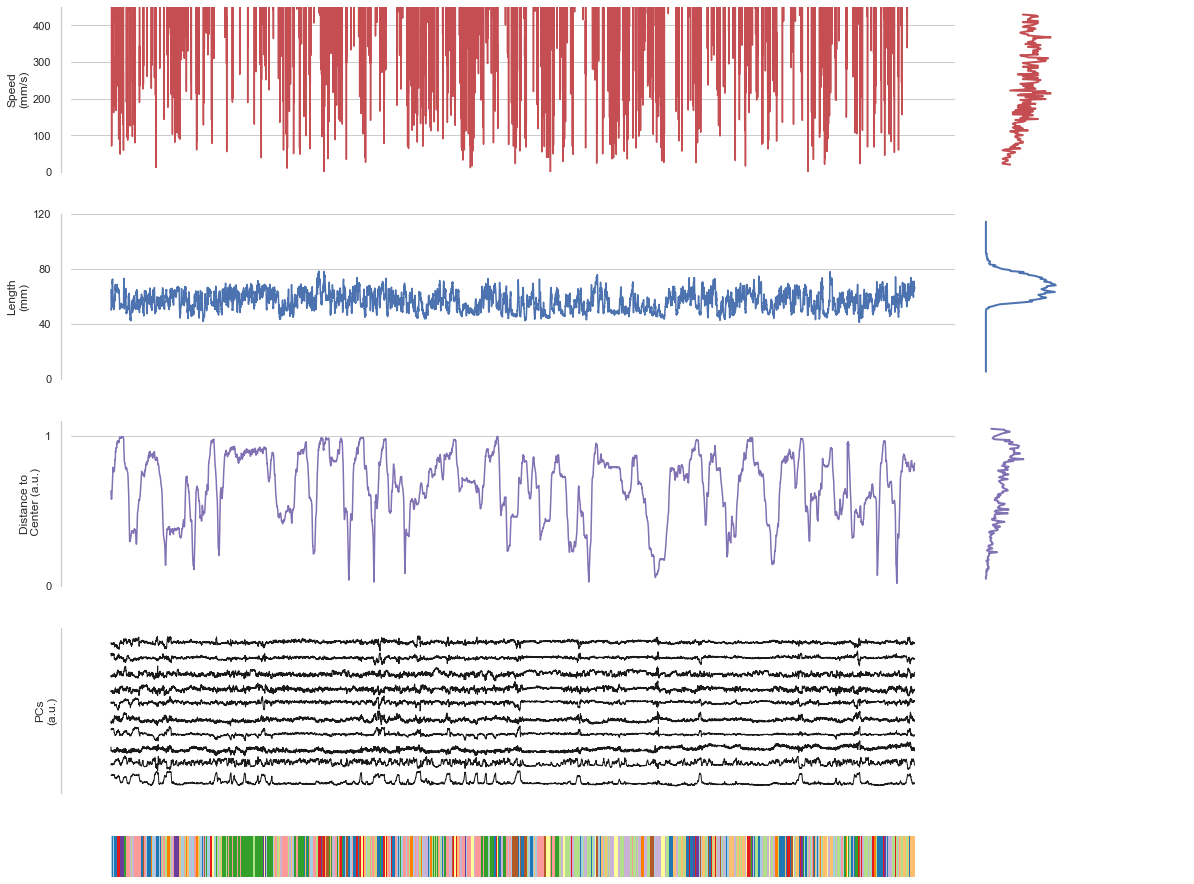

In [13]:
from moseq2_viz.util import h5_to_dict

pc_scores = h5_to_dict('/Users/sherry/Desktop/nate_zohreh/analysis_0628/_pca/pca_scores.h5')['scores']
pc_id = h5_to_dict('/Users/sherry/Desktop/nate_zohreh/analysis_0628/_pca/pca_scores.h5')['scores_idx']
print(np.max([v.shape[0] for v in pc_scores.values()]))
print(len(pc_scores.keys()))

for k in pc_id.keys():
    temp_ids = pc_id[k]
    pc_id[k]= temp_ids[~np.isnan(temp_ids)].astype(int)
    
target_mouse = '9d954655-4b50-4548-9707-01bf09124532'
target_subset = moseq_df[moseq_df.uuid == target_mouse].copy()
filename = 'wt_mouse'
df = {}
df['velocity'] = target_subset['velocity_2d_mm'].values
df['length'] = target_subset['length_mm'].values
df['dist_to_center'] = target_subset['dist_to_center_px'].values/np.max(target_subset['dist_to_center_px'])
df['syllable_labels'] = target_subset['labels (usage sort)'].values
df['data']= pc_scores[target_mouse]
x = np.arange(18000, 27000)

lengthfn = lambda df, ind: np.histogram(df['length'][ind], np.linspace(0,100,160))[0]
velocityfn = lambda df, ind: np.histogram(np.abs(30.0*df['velocity'][ind]), np.linspace(0,450,160))[0]
positionfn = lambda df, ind: np.histogram(df['dist_to_center'][ind], np.linspace(0,1,160))[0]

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
plt.figure(figsize=(20,16))
gs = matplotlib.gridspec.GridSpec(5,2,width_ratios=[4,1], height_ratios=[1,1,1,1,0.25], hspace=0.3, wspace=0.02)

plt.subplot(gs[0,0])
plt.plot(x/30.0,np.abs(30.*df['velocity'][x]), 'r')
plt.ylabel("Speed\n(mm/s)")
plt.yticks([0,100,200,300,400])
plt.xticks([])
plt.axis('tight')
plt.ylim(0,450)


plt.subplot(gs[0,1])
y = velocityfn(df,x).astype('float32')
y /= float(y.sum())
plt.plot(y, range(len(y)), 'r', linewidth=2)
plt.axis('off')
plt.xlim(-0.01,0.05)

plt.subplot(gs[1,0])
plt.plot(x/30.0,df['length'][x], 'b')
sns.despine(offset=10)
plt.ylabel("Length\n(mm)")
plt.yticks([0,40,80,120])
plt.axis('tight')
plt.xticks([])
plt.ylim(0,120)

plt.subplot(gs[1,1])
y = lengthfn(df,x).astype('float32')
y /= float(y.sum())
plt.plot(y, range(len(y)), 'b', linewidth=2)
plt.xticks([])
plt.axis('off')
plt.xlim(-0.01,0.1)

plt.subplot(gs[2,0])
plt.plot(x/30.0,df['dist_to_center'][x], 'm')
sns.despine(offset=10)
plt.ylabel("Distance to\n Center (a.u.)")
plt.axis('tight')
plt.xticks([])
plt.yticks([0, 1.0])
plt.ylim(0,1.1)

plt.subplot(gs[2,1])
y = positionfn(df,x).astype('float32')
y /= float(y.sum())
plt.plot(y, range(len(y)), 'm', linewidth=2)
plt.axis('tight')
plt.axis('off')
plt.xlim(-0.01,0.1)


plt.subplot(gs[3,0])
scale = 3
for i in range(10):
    y = ((df['data'][x,i]-np.nanmin(df['data'][x,i]))/(np.nanmax(df['data'][x,i])-np.nanmin(df['data'][x,i])) - 0.5)*3
    plt.plot(x / 30.0, y + i*scale, 'k', linewidth=1)
sns.despine(offset=10, bottom=True)
plt.ylabel("PCs\n(a.u.)")
plt.axis('tight')
print(plt.xticks())
plt.yticks([])
plt.xticks([])
xmin, xmax=plt.xlim()

plt.subplot(gs[4,0])
plt.imshow(df['syllable_labels'][None,x], interpolation='none', cmap='Paired',extent=[600, 900, 0,100])
plt.axis('tight')
plt.xlim(xmin, xmax)
plt.tight_layout()
plt.axis('off')

plt.savefig(f'{filename}.pdf')


figure S8E

In [14]:
scalar_mean = moseq_df.groupby(['uuid', 'SessionName', 'SubjectName', 'group'], as_index=False).mean()
scalar_std = moseq_df.groupby(['uuid', 'SessionName', 'SubjectName', 'group']).std().reset_index()

p_value of length_mm between HT and WT is 0.956
p_value of length_mm between HT and KO is 0.048
p_value of length_mm between WT and KO is 0.047


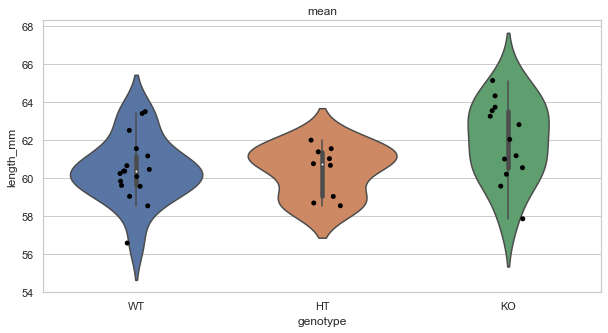

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

metric = 'length_mm'
wt = scalar_mean[scalar_mean.group =='WT'][metric].dropna()
ht = scalar_mean[scalar_mean.group =='HT'][metric].dropna()
ko = scalar_mean[scalar_mean.group =='KO'][metric].dropna()
print(f'p_value of {metric} between HT and WT is', np.round(stats.ttest_ind(ht, wt, equal_var=False).pvalue, 3))
print(f'p_value of {metric} between HT and KO is', np.round(stats.ttest_ind(ht,ko, equal_var=False).pvalue, 3))
print(f'p_value of {metric} between WT and KO is', np.round(stats.ttest_ind(wt,ko, equal_var=False).pvalue,3))

fig, ax = plt.subplots(1,1, figsize=(10, 5))
sns.set_theme(style="whitegrid")

sns.violinplot(ax= ax, x = 'group', y = metric, data=scalar_mean)
sns.stripplot(ax= ax, x = 'group', y = metric, data=scalar_mean, color='black')
ax.set_title('mean')
ax.set_xlabel('genotype')

scalar_mean[['group','uuid', metric]].to_csv('length-bygroup-mean.csv')


figure S8F

p_value of velocity_2d_mm between HT and WT is 0.506
p_value of velocity_2d_mm between HT and KO is 0.069
p_value of velocity_2d_mm between WT and KO is 0.007


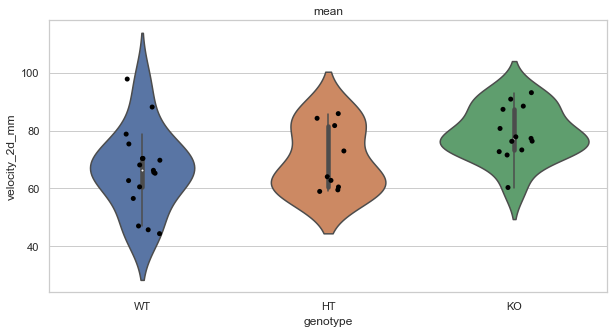

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

metric = 'velocity_2d_mm'
wt = scalar_mean[scalar_mean.group =='WT'][metric].dropna()
ht = scalar_mean[scalar_mean.group =='HT'][metric].dropna()
ko = scalar_mean[scalar_mean.group =='KO'][metric].dropna()
print(f'p_value of {metric} between HT and WT is', np.round(stats.ttest_ind(ht, wt, equal_var=False).pvalue, 3))
print(f'p_value of {metric} between HT and KO is', np.round(stats.ttest_ind(ht,ko, equal_var=False).pvalue, 3))
print(f'p_value of {metric} between WT and KO is', np.round(stats.ttest_ind(wt,ko, equal_var=False).pvalue,3))

fig, ax = plt.subplots(1,1, figsize=(10, 5))
sns.set_theme(style="whitegrid")

sns.violinplot(ax= ax, x = 'group', y = metric, data=scalar_mean)
sns.stripplot(ax= ax, x = 'group', y = metric, data=scalar_mean, color='black')
ax.set_title('mean')
ax.set_xlabel('genotype')

fig.savefig('velocity-bygroup.pdf')

scalar_mean[['group','uuid', metric]].to_csv('velocity-bygroup-mean.csv')

figure S8G

In [17]:
import pandas as pd
import numpy as np
import seaborn as sns

def compute_diff_dist(scalar_df: pd.DataFrame):
    scalar_df = scalar_df[['centroid_x_mm', 'centroid_y_mm']].dropna()
    return np.sqrt((scalar_df[['centroid_x_mm', 'centroid_y_mm']].diff()**2).sum(1)).sum()/1000

m = 0
syll_block = [m]
syll_array = moseq_df['labels (usage sort)'].values
for i in range(1, len(syll_array)):
    if syll_array[i] != syll_array[i-1]:
        m+=1
    syll_block.append(m)
moseq_df['syll_block'] = syll_block

dist_df_all = moseq_df.groupby(['group', 'uuid']).apply(compute_diff_dist).reset_index().rename(columns = {'labels (usage sort)': 'syllable', 0:'total_distance'})

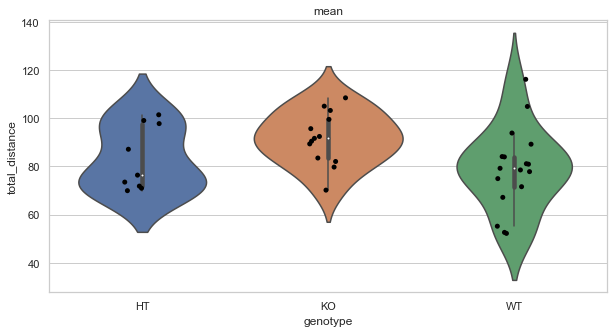

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
plt.rcParams["pdf.fonttype"] = 42

fig, axs = plt.subplots(1,1, figsize=(10, 5))
sns.set_theme(style="whitegrid")

sns.violinplot(ax= axs, x = 'group', y = 'total_distance', data=dist_df_all)
sns.stripplot(ax= axs, x = 'group', y ='total_distance', data=dist_df_all, color='black')
axs.set_title('mean')
axs.set_xlabel('genotype')
fig.savefig('total_distancebygroup.pdf')

figure S8H

In [25]:
moseq_df = pd.read_csv('./moseq_df.csv')

In [26]:
max_dtc = moseq_df.groupby(['uuid']).max()['dist_to_center_px'].reset_index().rename(columns = {'dist_to_center_px': 'max_dtc'})
moseq_df = pd.merge(moseq_df, max_dtc, on = 'uuid', how = 'left')
moseq_df['dist_to_center_norm'] = moseq_df['dist_to_center_px']/moseq_df['max_dtc']

scalar_mean = moseq_df.groupby(['uuid', 'SessionName', 'SubjectName', 'group'], as_index=False).mean()
scalar_std = moseq_df.groupby(['uuid', 'SessionName', 'SubjectName', 'group']).std().reset_index()

p_value of dist_to_center_norm between HT and WT is 0.164
p_value of dist_to_center_norm between HT and KO is 0.679
p_value of dist_to_center_norm between WT and KO is 0.535


Text(0.5, 0, 'genotype')

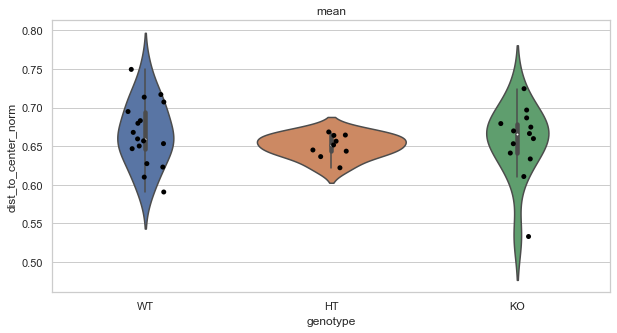

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

metric = 'dist_to_center_norm'
wt = scalar_mean[scalar_mean.group =='WT'][metric].dropna()
ht = scalar_mean[scalar_mean.group =='HT'][metric].dropna()
ko = scalar_mean[scalar_mean.group =='KO'][metric].dropna()
print(f'p_value of {metric} between HT and WT is', np.round(stats.ttest_ind(ht, wt, equal_var=False).pvalue, 3))
print(f'p_value of {metric} between HT and KO is', np.round(stats.ttest_ind(ht,ko, equal_var=False).pvalue, 3))
print(f'p_value of {metric} between WT and KO is', np.round(stats.ttest_ind(wt,ko, equal_var=False).pvalue,3))

fig, ax = plt.subplots(1,1, figsize=(10, 5))
sns.set_theme(style="whitegrid")

sns.violinplot(ax= ax, x = 'group', y = metric, data=scalar_mean)
sns.stripplot(ax= ax, x = 'group', y = metric, data=scalar_mean, color='black')
ax.set_title('mean')
ax.set_xlabel('genotype')


figure 7I


In [28]:
# drug data from previous publication in https://github.com/dattalab/moseq-drugs
ds = './dataset.pkl'
fingerprint = './fingerprints.pkl'
syllabel='./syllablelabels.pkl'

In [29]:
import pickle

with open(ds,'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    dataset = u.load()

with open(syllabel, 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    syll_label = u.load()

with open(fingerprint, 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    fingerprint = u.load()

In [30]:
import re
ds_list = []
for n in dataset.keys():
    subject = n
    temp_df = pd.DataFrame({})
    for scalar in ['angle', 'dist_to_center', 'area', 'centroid_y', 'height', 'width', 'length', 'velocity', 'centroid_x']:
        temp_df[scalar]=dataset[subject][scalar].squeeze()
    result = re.search( r"(.*)_(.*)_(.*)", n)
    # print(result.group(2))
    temp_df['SessionName'] = n
    temp_df['drug'] = n.split('_')[2]
    temp_df['dosage'] = n.split('_')[1]
    temp_df['group'] = '_'.join([n.split('_')[2], n.split('_')[1]])
    ds_list.append(temp_df)

In [31]:
scalar_df = pd.concat(ds_list, axis=0)
scalar_df['syllable_labels']=syll_label
scalar_df.head()
scalar_df['syllable_labels'] = scalar_df.syllable_labels.fillna(-5)
scalar_df['onset'] = np.insert(np.diff(scalar_df.syllable_labels), 0, 0)!=0
scalar_df['velocity'] =np.abs(scalar_df['velocity'])

In [32]:
groupby= ['group', 'SessionName']
groupby_with_syllable = ['group', 'SessionName', 'syllable_labels']
scalar_df = scalar_df.query('`syllable_labels` >=0')
syllable_key = 'syllable_labels'
usage_normalization=True
usages = (
            scalar_df.query("onset")
                .groupby(groupby)[syllable_key]
                .value_counts(normalize=usage_normalization)
        )
usages = (usages
              .unstack(fill_value=0)
              .reset_index()
              .melt(id_vars=groupby)
              .set_index(groupby_with_syllable))
usages.columns = ["usage"]
usages = usages.reset_index()
usages['join_column'] = usages['SessionName'] + usages['syllable_labels'].astype(str)
usages = usages.drop(['group', 'SessionName', 'syllable_labels'], axis = 1)
mean_df = scalar_df.groupby(['group', 'SessionName', 'syllable_labels']).mean().reset_index()
mean_df['join_column'] = mean_df['SessionName'] + mean_df['syllable_labels'].astype(str)
mean_df = pd.merge(usages, mean_df, how='inner', on='join_column').drop(['join_column'], axis = 1)

In [33]:
stats_df = mean_df[mean_df.group.isin(['.25mgkg_haloperidol', 'clozapine_10mgkg'])].copy()
control_df = mean_df[mean_df.group.isin(['control_second','1-20-14_control', '1-20-15_control','5-12-15_control3', '5-20-15_control4', '6-1-15_control5', '6-26-15_control6'])].copy()
control_df['group'] = 'control'
stats_df = pd.concat([stats_df, control_df], axis = 0)

In [34]:
moseq_df = scalar_df[scalar_df.group.isin(['.25mgkg_haloperidol', 'clozapine_10mgkg'])].copy()
control_df = scalar_df[scalar_df.group.isin(['control_second','1-20-14_control', '1-20-15_control','5-12-15_control3', '5-20-15_control4', '6-1-15_control5', '6-26-15_control6'])].copy()
control_df['group'] = 'control'
moseq_df = pd.concat([moseq_df, control_df], axis = 0)

In [35]:
stats_df = stats_df.rename({'syllable_labels': 'syllable'}, axis = 1)
stats_df['velocity'] *=30
moseq_df['velocity'] *=30

dist_df = pd.read_csv('./dist_df_k1.csv')
dist_subset = dist_df[dist_df.total_distance< 100000]

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

genotype_kinematics = stats_df[['group', 'syllable', 'usage', 'velocity']].copy().groupby(['group', 'syllable']).mean().reset_index().dropna()
genotype_kinematics = genotype_kinematics[genotype_kinematics.usage >0.001]
syll_v = genotype_kinematics.groupby('syllable').mean()['velocity'].reset_index()

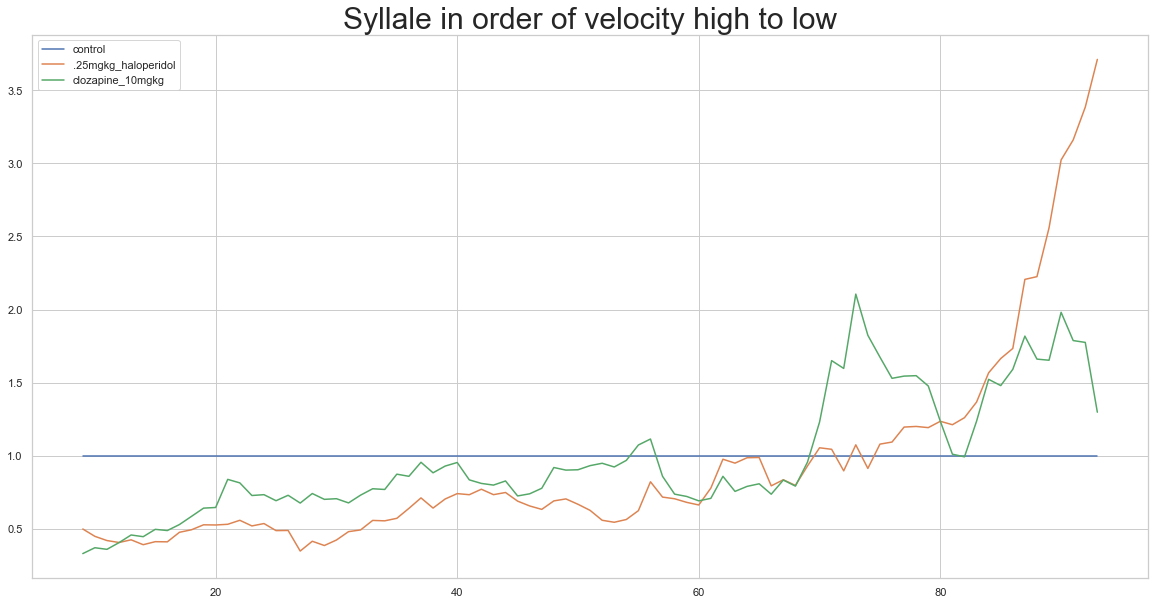

In [37]:
ref = syll_v
roll_num= 10
sort_by = 'velocity'
sns.set_theme(style="whitegrid")
relative_u = pd.pivot_table(genotype_kinematics, values = 'usage', index='syllable', columns = 'group').reset_index()
relative_u = pd.merge(relative_u, ref, left_on='syllable', right_on='syllable')
relative_u = relative_u.sort_values(by=[sort_by], ascending=False).dropna().reset_index()
rolling = pd.DataFrame({'control': relative_u['control'].rolling(roll_num).mean(),

                        '.25mgkg_haloperidol': relative_u['.25mgkg_haloperidol'].rolling(roll_num).mean(),
                        'clozapine_10mgkg': relative_u['clozapine_10mgkg'].rolling(roll_num).mean()}).dropna()
rolling['.25mgkg_haloperidol'] =rolling['.25mgkg_haloperidol']/rolling['control']
rolling['clozapine_10mgkg'] =rolling['clozapine_10mgkg']/rolling['control']
rolling['control'] =rolling['control']/rolling['control']
fig, ax = plt.subplots(1, 1, figsize=(20,10))
sns.lineplot(data = rolling, ax = ax, dashes=False)
ax.set_title(f'Syllale in order of {sort_by} high to low', fontsize = 30)
fig.savefig('drugvh-to-l.pdf')

figure 7J

In [38]:
from tqdm.auto import trange
def permutation_test(box, rest, sample_size = 99999):
    x = np.hstack([box, rest])
    n_box = len(box)
    perm_mean = np.zeros(sample_size)
    for i in trange(sample_size):
        np.random.seed(i) 
        # compute shuffle box mean - rest mean
        perm_x = np.random.permutation(x)
        perm_mean[i] = perm_x[:n_box].mean() - perm_x[n_box:].mean()
    return (np.sum((box.mean()-rest.mean())<perm_mean) +1)/ (sample_size+1)
from scipy.stats import ttest_ind

def bootstrap(box, rest, sample_size = 1000, sample_iter=100000):
    b_mean_box = np.zeros(sample_iter)
    b_mean_rest= np.zeros(sample_iter)
    for i in trange(sample_iter):
        np.random.seed(i)
        b_mean_box[i]=np.random.choice(box, sample_size).mean()
        b_mean_rest[i]=np.random.choice(rest, sample_size).mean()
    return np.percentile(b_mean_box, [2.5,97.5]), np.percentile(b_mean_rest, [2.5, 97.5])

In [39]:
box_1 = relative_u['syllable'][:15].tolist()

['.25mgkg_haloperidol' 'control']
[50.0, 51.0, 127.0, 59.0, 29.0, 58.0, 64.0, 20.0, 63.0, 13.0, 9.0, 69.0, 37.0, 65.0, 124.0]


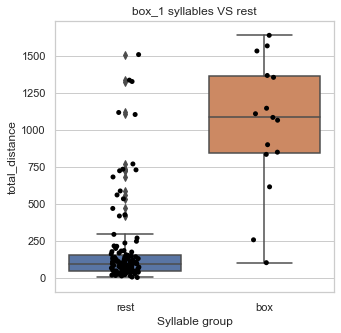

file name hal_ctrl_vh-to-ldistance-box_1.pdf


In [40]:
box = box_1
name = 'box_1'
pair = ('.25mgkg_haloperidol', 'control')
box, rest = plot_boxvsrest(dist_subset, box, name,pair, 'total_distance', 'hal_ctrl_vh-to-ldistance')

In [41]:
print(permutation_test(box, rest))
print(ttest_ind(box, rest, equal_var=False))
b_ci, r_ci = bootstrap(box,rest)
print('box CI:', b_ci, 'rest CI:', r_ci)

  1%|          | 1158/100000 [00:00<00:08, 11579.32it/s]

1e-05
Ttest_indResult(statistic=7.026589941705768, pvalue=3.5523553598372214e-06)


100%|██████████| 100000/100000 [00:08<00:00, 11454.97it/s]

box CI: [ 999.44487792 1053.93315875] rest CI: [168.11491987 203.03130405]


figure 7K

['clozapine_10mgkg' 'control']
[50.0, 51.0, 127.0, 59.0, 29.0, 58.0, 64.0, 20.0, 63.0, 13.0, 9.0, 69.0, 37.0, 65.0, 124.0]


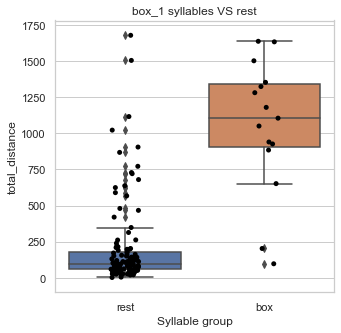

file name cloz_ctrl_vh-to-ldistance_NEW-box_1.pdf


In [42]:
box = box_1
name = 'box_1'
pair = ('clozapine_10mgkg', 'control')
box, rest = plot_boxvsrest(dist_subset, box, name,pair, 'total_distance', 'cloz_ctrl_vh-to-ldistance_NEW')

In [43]:
print(permutation_test(box, rest))
print(ttest_ind(box, rest, equal_var=False))
b_ci, r_ci = bootstrap(box,rest)
print('box CI:', b_ci, 'rest CI:', r_ci)

  1%|          | 1129/100000 [00:00<00:08, 11286.16it/s]

1e-05
Ttest_indResult(statistic=6.988894030187238, pvalue=3.7888328009985384e-06)


100%|██████████| 100000/100000 [00:08<00:00, 11327.99it/s]

box CI: [1023.20774829 1078.59511715] rest CI: [182.80581703 218.34427763]


['clozapine_10mgkg' 'control']
[50.0, 51.0, 127.0, 59.0, 29.0, 58.0, 64.0, 20.0, 63.0, 13.0, 9.0, 69.0, 37.0, 65.0, 124.0]


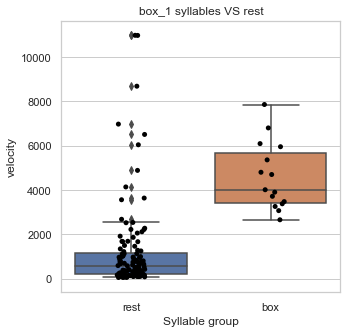

file name cloz_ctrl_vh-to-lspeed_NEW-box_1.pdf


In [44]:
box = box_1
name = 'box_1'
pair = ('clozapine_10mgkg', 'control')
box, rest = plot_boxvsrest(stats_df, box, name,pair, 'velocity', 'cloz_ctrl_vh-to-lspeed_NEW')

In [45]:
print(permutation_test(box, rest))
print(ttest_ind(box, rest, equal_var=False))
b_ci, r_ci = bootstrap(box,rest)
print('box CI:', b_ci, 'rest CI:', r_ci)

  1%|          | 1113/100000 [00:00<00:08, 11121.55it/s]

1e-05
Ttest_indResult(statistic=7.938583595875927, pvalue=1.2817854122908342e-07)


100%|██████████| 100000/100000 [00:08<00:00, 11356.41it/s]

box CI: [4504.78551111 4687.41847502] rest CI: [1064.87287516 1302.33709615]


['clozapine_10mgkg' 'control']
[50.0, 51.0, 127.0, 59.0, 29.0, 58.0, 64.0, 20.0, 63.0, 13.0, 9.0, 69.0, 37.0, 65.0, 124.0]


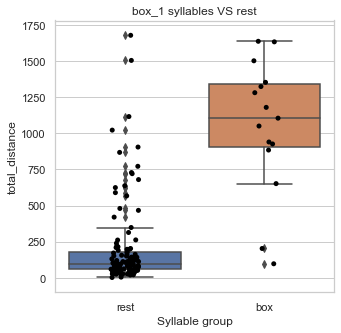

file name cloz_ctrl_vh-to-ldistance_NEW-box_1.pdf


In [46]:
box = box_1
name = 'box_1'
pair = ('clozapine_10mgkg', 'control')
box, rest = plot_boxvsrest(dist_subset, box, name,pair, 'total_distance', 'cloz_ctrl_vh-to-ldistance_NEW')

In [47]:
print(permutation_test(box, rest))
print(ttest_ind(box, rest, equal_var=False))
b_ci, r_ci = bootstrap(box,rest)
print('box CI:', b_ci, 'rest CI:', r_ci)

  1%|          | 1075/100000 [00:00<00:09, 10742.05it/s]

1e-05
Ttest_indResult(statistic=6.988894030187238, pvalue=3.7888328009985384e-06)


100%|██████████| 100000/100000 [00:09<00:00, 10807.74it/s]

box CI: [1023.20774829 1078.59511715] rest CI: [182.80581703 218.34427763]
